In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [22]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)
end

addIncreasingCnsts (generic function with 1 method)

In [23]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [24]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [25]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Apr_weekend.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [26]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 497.44432
  (4,4) => 0.0
  (3,1) => 1915.895466
  (4,5) => 0.051761
  (2,4) => 1218.194422
  (6,5) => 0.116915
  (8,4) => 1155.535764
  (1,2) => 0.0
  (5,1) => 0.031423
  (3,4) => 142.564185
  (8,2) => 2.0e-6
  (2,3) => 0.0
  (2,6) => 0.0
  (5,4) => 0.061134
  (2,1) => 759.807293
  (2,5) => 0.0
  (8,5) => 1221.975421
  (1,4) => 0.0
  (2,8) => 0.0
  (5,8) => 173.253629
  (4,8) => 1072.75666
  (7,8) => 333.942788
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 563.296602
  ⋮     => ⋮

In [27]:
using JSON

link_day_minute_Apr_dict = readall("../temp_files/link_day_minute_Apr_dict_JSON.json");
link_day_minute_Apr_dict = replace(link_day_minute_Apr_dict, "NaN", 0);

link_day_minute_Apr_dict = JSON.parse(link_day_minute_Apr_dict);

In [28]:
# weekend_Apr_list = [1, 7, 8, 14, 15, 21, 22, 28, 29]

# training set 1
weekend_Apr_list_1 = [1, 7, 8, 14, 15, 21]

# training set 2
weekend_Apr_list_2 = [14, 15, 21, 22, 28, 29]

# training set 3
weekend_Apr_list_3 = [1, 7, 8, 22, 28, 29]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in weekend_Apr_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in weekend_Apr_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in weekend_Apr_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["MD_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["MD_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [29]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)
flow_data_2 = Array(Float64, length(arcs_2[1]), numData)
flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [30]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [497.44432,497.44432,497.44432,497.44432,497.44432,497.44432]
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [1915.895466,1915.895466,1915.895466,1915.895466,1915.895466,1915.89…
  (4,5) => [0.051761,0.051761,0.051761,0.051761,0.051761,0.051761]
  (2,4) => [1218.194422,1218.194422,1218.194422,1218.194422,1218.194422,1218.19…
  (6,5) => [0.116915,0.116915,0.116915,0.116915,0.116915,0.116915]
  (8,4) => [1155.535764,1155.535764,1155.535764,1155.535764,1155.535764,1155.53…
  (1,2) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,1) => [0.031423,0.031423,0.031423,0.031423,0.031423,0.031423]
  (3,4) => [142.564185,142.564185,142.564185,142.564185,142.564185,142.564185]
  (8,2) => [2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6,2.0e-6]
  (2,3) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (2,6) => [0.0,0.0,0.0,0.0,0.0,0.0]
  (5,4) => [0.061134,0.061134,0.061134,0.061134,0.061134,0.061134]
  (2,1) => [759.807293,759.807293,759.807293,759.807293,759.807293,759.807293]
 

In [31]:
flow_data_3

24x6 Array{Float64,2}:
 2624.46  2649.52  2744.4   2569.11  2663.73  2703.76
 2872.33  2859.08  2957.02  2879.09  2851.15  2884.24
 2301.18  2403.84  2310.64  2322.73  2298.9   2280.85
 2406.53  2525.06  2580.34  2450.04  2501.52  2475.46
 2302.84  2325.23  2362.66  2316.69  2326.98  2328.54
 2429.99  2355.7   2361.75  2319.96  2315.32  2386.6 
 2878.21  2865.95  2984.1   2848.44  2900.6   2848.44
 2923.29  2833.71  2855.35  2980.59  2884.98  2871.69
 2211.98  2222.56  2260.79  2254.13  2200.48  2305.94
 2422.53  2354.49  2488.6   2409.88  2346.22  2349.04
 2560.5   2568.23  2717.42  2533.79  2682.84  2550.19
 2333.46  2360.86  2396.07  2399.13  2327.15  2504.96
 2334.12  2668.72  2777.62  2697.86  2682.18  2727.34
 2640.73  2798.2   2746.86  2630.1   2706.6   2646.15
 2458.32  2389.69  2500.98  2466.42  2384.14  2333.87
 2391.66  2357.92  2383.51  2378.59  2335.49  2380.07
 1792.23  1888.85  1904.48  1882.12  1867.84  1874.68
 2693.4   2782.04  2858.31  2755.7   2697.02  2762.34
 2360

In [32]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [33]:
#include("trafficCval.jl")

coeffs_dict_Apr_weekend = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Apr_weekend[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Apr_weekend[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Apr_weekend[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [34]:
outfile = open("../temp_files/coeffs_dict_Apr_weekend.json", "w")

JSON.print(outfile, coeffs_dict_Apr_weekend)

close(outfile)

In [35]:
coeffs_dict_Apr_weekend_ = readall("../temp_files/coeffs_dict_Apr_weekend.json")
coeffs_dict_Apr_weekend_ = JSON.parse(coeffs_dict_Apr_weekend_)

Dict{String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.036696014163858634,0.03580484869445316,0.0194879…
  "(5,0.5,100.0,3)"   => {1.0,0.007590332710070051,0.02763395256576141,0.0401346…
  "(6,1.5,10.0,3)"    => {1.0,0.027534821731105802,0.03719957427645199,0.0268201…
  "(6,2.0,0.1,2)"     => {1.0,-0.029158587109897466,0.05192375562612971,0.070230…
  "(4,0.5,1000.0,1)"  => {1.0,0.015166790497409533,0.03849626393840797,0.0418558…
  "(6,2.0,0.01,1)"    => {1.0,-0.4172825713364996,0.160783717794975,0.3589012971…
  "(8,1.5,0.01,1)"    => {1.0,-0.23694868886137074,-0.07783922393813347,0.194698…
  "(5,1.5,1.0,1)"     => {1.0,0.03347243607289582,0.0392147218510061,0.023063969…
  "(8,2.5,0.001,2)"   => {1.0,-0.20559764020791874,-0.2670275674256238,0.3718365…
  "(4,2.0,0.1,1)"     => {1.0,0.037500930017266496,0.04422425907731425,0.0155717…
  "(5,1.0,1000.0,2)"  => {1.0,0.022998326019291204,0.03768446822742501,0.0307215…
  "(4,2.0,0.1,2)"     => {1.0,0.04478332660586843,0.03530018430

In [36]:
coeffs_dict_Apr_weekend_["(8,0.5,10000.0,1)"]

9-element Array{Any,1}:
  1.0       
 -0.00465003
  0.0533809 
 -0.201403  
  0.62237   
 -0.898012  
  0.95413   
 -0.462383  
  0.111314  

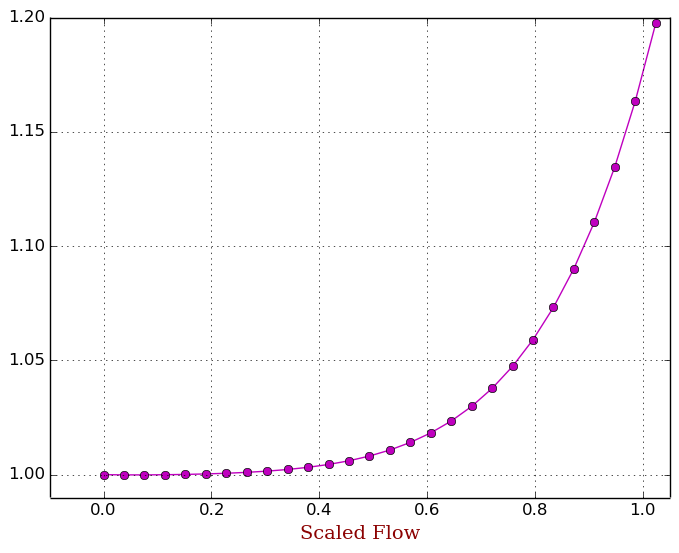

In [37]:
using PyPlot

fcoeffs = coeffs_dict_Apr_weekend_["(8,0.5,10.0,3)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Apr_weekend")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_weekend.pdf")